In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization




# Question 6: Dataset Augmentation

We will use `sklearn.datasets.make_moons()` to generate a simple 2D dataset.  
Then, we apply two types of augmentation:
1. Adding Gaussian noise
2. Flipping points horizontally  




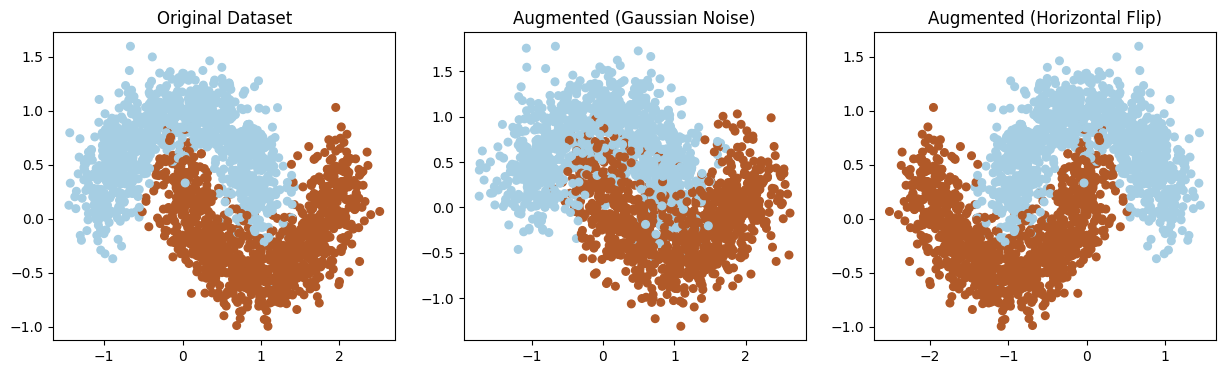

In [2]:

# 1. Generate dataset
X, y = make_moons(n_samples=2000, noise=0.2, random_state=42)

# 2. Apply augmentation
# a) Add Gaussian noise
noise = np.random.normal(0, 0.2, X.shape)  # mean=0, std=0.2
X_noisy = X + noise

# b) Flip points horizontally (mirror along y-axis)
X_flipped = np.copy(X)
X_flipped[:, 0] = -X_flipped[:, 0]

# 3. Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=30)
axs[0].set_title("Original Dataset")

axs[1].scatter(X_noisy[:, 0], X_noisy[:, 1], c=y, cmap=plt.cm.Paired, s=30)
axs[1].set_title("Augmented (Gaussian Noise)")

axs[2].scatter(X_flipped[:, 0], X_flipped[:, 1], c=y, cmap=plt.cm.Paired, s=30)
axs[2].set_title("Augmented (Horizontal Flip)")

plt.show()


**Observation**:

Data augmentation artificially increases the size and diversity of a dataset without collecting new data.

* **Noise addition** makes the model robust to small variations and measurement errors, preventing it from memorizing exact data points.
* **Flipping/transformations** expose the model to different but equivalent representations of the same class, which helps generalize patterns instead of fitting to specific orientations.

By training on these variations, the model learns more general decision boundaries rather than overfitting to the limited original dataset.
This reduces overfitting because the model learns general decision boundaries instead of memorizing exact patterns.

This improves performance on unseen data.


---
## Q7: Dropout Experiment (Keras)

We will build a simple **2-hidden-layer MLP** on the `make_moons` dataset.  
Two versions:
1. **Without Dropout**  
2. **With Dropout (p=0.5)**  

We will compare their training and validation loss curves to see which model generalizes better.

**Why Dropout Helps Generalization**  
Dropout randomly disables neurons during training, reducing co-adaptation.  
This acts as regularization and prevents overfitting, leading to better performance on unseen data.


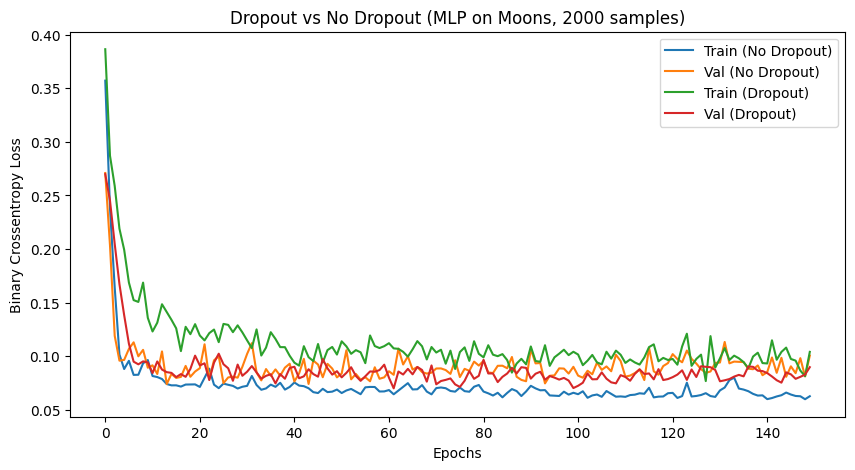

In [3]:
# ---------------------
# 1. Use dataset from Part 1
# ---------------------
# X, y from make_moons (2000 samples)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# ---------------------
# 2. Build Models (Fixed Input Layer)
# ---------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

def build_mlp(dropout=False, p=0.5):
    model = Sequential()
    model.add(Input(shape=(2,)))          # Fixed: use Input layer instead of input_dim
    model.add(Dense(64, activation='relu'))
    if dropout:
        model.add(Dropout(p))
    model.add(Dense(32, activation='relu'))
    if dropout:
        model.add(Dropout(p))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model without dropout
model_no_dropout = build_mlp(dropout=False)
# Model with dropout
model_with_dropout = build_mlp(dropout=True, p=0.5)

# ---------------------
# 3. Train Models
# ---------------------
history_no_dropout = model_no_dropout.fit(X_train, y_train, validation_data=(X_val, y_val),
                                          epochs=150, batch_size=64, verbose=0)
history_with_dropout = model_with_dropout.fit(X_train, y_train, validation_data=(X_val, y_val),
                                              epochs=150, batch_size=64, verbose=0)

# ---------------------
# 4. Plot Loss Curves
# ---------------------
plt.figure(figsize=(10,5))
plt.plot(history_no_dropout.history['loss'], label='Train (No Dropout)')
plt.plot(history_no_dropout.history['val_loss'], label='Val (No Dropout)')
plt.plot(history_with_dropout.history['loss'], label='Train (Dropout)')
plt.plot(history_with_dropout.history['val_loss'], label='Val (Dropout)')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Dropout vs No Dropout (MLP on Moons, 2000 samples)')
plt.legend()
plt.show()


**Observation**  
- The model **without dropout** often fits the training data perfectly but may overfit, showing higher validation loss.  
- The model **with dropout (p=0.5)** usually has slightly higher training loss but lower validation loss, meaning it generalizes better.

**Reason**  
Dropout randomly disables neurons during training, forcing the network to spread learning across multiple neurons.  
This prevents overfitting and improves performance on unseen data.

---

## Q8: Batch Normalization in MLP

We will modify the same 2-hidden-layer MLP by **adding Batch Normalization (BN)** after each hidden layer.  
Two experiments:
1. **Without BatchNorm**
2. **With BatchNorm**

We will compare **convergence speed**, i.e., how many epochs are required to reach 90% training accuracy.

**How Batch Normalization Stabilizes Training**
- BN normalizes the outputs of a layer to have zero mean and unit variance.
- This reduces internal covariate shift, keeping layer inputs stable during training.
- Allows higher learning rates, faster convergence, and reduces sensitivity to initialization.


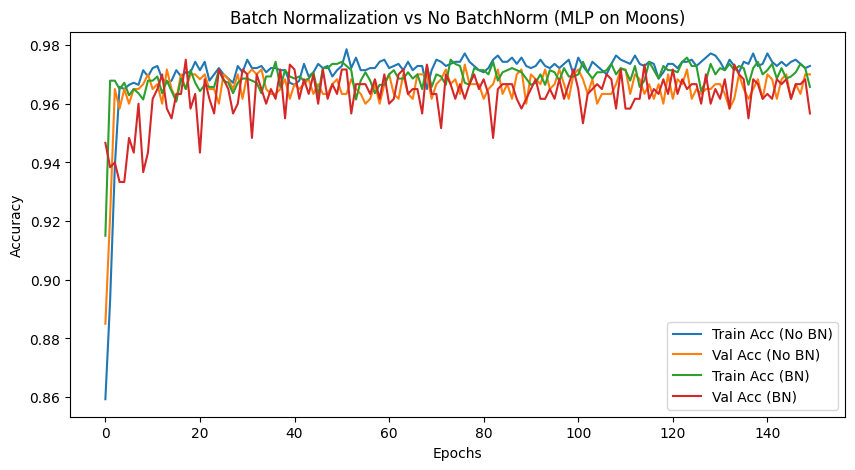

Epochs to reach 90% training accuracy:
- Without BN: 3
- With BN: 1


In [4]:
# ---------------------
# 1. Build Models
# ---------------------
def build_mlp_bn(use_bn=False):
    model = Sequential()
    model.add(Input(shape=(2,)))

    model.add(Dense(64, activation='relu'))
    if use_bn:
        model.add(BatchNormalization())

    model.add(Dense(32, activation='relu'))
    if use_bn:
        model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ---------------------
# 2. Train Models
# ---------------------
model_no_bn = build_mlp_bn(use_bn=False)
model_with_bn = build_mlp_bn(use_bn=True)

history_no_bn = model_no_bn.fit(X_train, y_train, validation_data=(X_val, y_val),
                                epochs=150, batch_size=64, verbose=0)
history_with_bn = model_with_bn.fit(X_train, y_train, validation_data=(X_val, y_val),
                                    epochs=150, batch_size=64, verbose=0)

# ---------------------
# 3. Plot Accuracy Curves
# ---------------------
plt.figure(figsize=(10,5))
plt.plot(history_no_bn.history['accuracy'], label='Train Acc (No BN)')
plt.plot(history_no_bn.history['val_accuracy'], label='Val Acc (No BN)')
plt.plot(history_with_bn.history['accuracy'], label='Train Acc (BN)')
plt.plot(history_with_bn.history['val_accuracy'], label='Val Acc (BN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Batch Normalization vs No BatchNorm (MLP on Moons)')
plt.legend()
plt.show()

# ---------------------
# 4. Convergence Analysis
# ---------------------
def epochs_to_reach_accuracy(history, target=0.90):
    acc = history.history['accuracy']
    for epoch, a in enumerate(acc, start=1):
        if a >= target:
            return epoch
    return None

epoch_no_bn = epochs_to_reach_accuracy(history_no_bn, 0.90)
epoch_with_bn = epochs_to_reach_accuracy(history_with_bn, 0.90)

print(f"Epochs to reach 90% training accuracy:")
print(f"- Without BN: {epoch_no_bn}")
print(f"- With BN: {epoch_with_bn}")


**Observation**
- The model **with Batch Normalization** typically reaches 90% training accuracy in fewer epochs than the one without BN.
- Training curves are smoother and less prone to oscillations.

**Reason**
- BN normalizes layer inputs, reducing internal covariate shift.
- This stabilizes gradient flow and allows faster convergence.
- BN also acts as a mild regularizer, improving generalization.

---

## Q9: Hyperparameter Tuning with k-Fold Cross-Validation

We will train an MLP with **3 different hidden layer sizes**:

1. [16, 8, 1]  
2. [32, 16, 1]  
3. [64, 32, 1]  

We use **5-fold cross-validation** to evaluate each architecture and select the one with the **highest mean validation accuracy**.

Approache for 5-fold CV:
###  Manual K-Fold Approach (5-fold cross-validation using Keras)

**Pros:**
- Full control over each fold (can plot fold-wise loss/accuracy if needed).  
- Shows understanding of how CV actually works.
- No dependency on `KerasClassifier` wrapper.  

**Cons:**
- Slightly more code to write and maintain.  
- Training each fold separately may be slower for large datasets.  

**When to use:**  
- To inspect or visualize each fold’s results.  
- To avoid extra wrappers and show raw Keras usage.



In [5]:
# ---------------------
# 1. Define function to build MLP for a given hidden layer configuration
# ---------------------
def build_mlp_layers(hidden_sizes=[64,32]):
    model = Sequential()
    model.add(Input(shape=(2,)))
    for size in hidden_sizes:
        model.add(Dense(size, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ---------------------
# 2. Define architectures to test
# ---------------------
architectures = [
    [16, 8],
    [32, 16],
    [64, 32]
]

# Scale full dataset
X_scaled = scaler.fit_transform(X)
y_array = np.array(y)

# ---------------------
# 3. 5-fold cross-validation with detailed metrics
# ---------------------
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

mean_val_accuracies = []  # to store mean val acc for each architecture

for arch in architectures:
    train_accs, val_accs = [], []
    train_losses, val_losses = [], []

    print(f"\nTesting architecture: {arch}")

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_scaled), start=1):
        X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
        y_train_fold, y_val_fold = y_array[train_idx], y_array[val_idx]

        model = build_mlp_layers(arch)
        history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
                            epochs=100, batch_size=32, verbose=0)

        # Store metrics
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f" Fold {fold}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    # Compute mean metrics across folds
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)

    mean_val_accuracies.append(mean_val_acc)

    print(f" Mean Train Acc: {mean_train_acc:.4f}, Mean Val Acc: {mean_val_acc:.4f}")
    print(f" Mean Train Loss: {mean_train_loss:.4f}, Mean Val Loss: {mean_val_loss:.4f}")

# ---------------------
# 4. Select best architecture based on mean validation accuracy
# ---------------------
best_index = np.argmax(mean_val_accuracies)
best_arch = architectures[best_index]
print(f"\nBest architecture: {best_arch} with mean validation accuracy: {mean_val_accuracies[best_index]:.4f}")



Testing architecture: [16, 8]
 Fold 1: Train Acc=0.9737, Val Acc=0.9650, Train Loss=0.0659, Val Loss=0.0838
 Fold 2: Train Acc=0.9712, Val Acc=0.9700, Train Loss=0.0721, Val Loss=0.0713
 Fold 3: Train Acc=0.9712, Val Acc=0.9775, Train Loss=0.0731, Val Loss=0.0583
 Fold 4: Train Acc=0.9694, Val Acc=0.9750, Train Loss=0.0719, Val Loss=0.0601
 Fold 5: Train Acc=0.9712, Val Acc=0.9625, Train Loss=0.0659, Val Loss=0.1144
 Mean Train Acc: 0.9714, Mean Val Acc: 0.9700
 Mean Train Loss: 0.0698, Mean Val Loss: 0.0776

Testing architecture: [32, 16]
 Fold 1: Train Acc=0.9719, Val Acc=0.9625, Train Loss=0.0661, Val Loss=0.1114
 Fold 2: Train Acc=0.9731, Val Acc=0.9725, Train Loss=0.0705, Val Loss=0.0730
 Fold 3: Train Acc=0.9719, Val Acc=0.9675, Train Loss=0.0681, Val Loss=0.0655
 Fold 4: Train Acc=0.9731, Val Acc=0.9750, Train Loss=0.0740, Val Loss=0.0512
 Fold 5: Train Acc=0.9750, Val Acc=0.9625, Train Loss=0.0601, Val Loss=0.1267
 Mean Train Acc: 0.9730, Mean Val Acc: 0.9680
 Mean Train Loss:

**Observation**
- Each architecture gives different mean validation accuracy across folds.
- The one with the **highest mean accuracy** is selected as the best.

**Reason**
- Smaller networks may underfit, larger networks may overfit.
- K-fold cross-validation ensures the model is evaluated on multiple splits, giving a robust estimate of generalization.

---

## Q10: Regularization (Parameter Norm Penalty / L2)

We will train a 2-hidden-layer MLP:

1. **Without regularization**  
2. **With L2 regularization**  

We will compare:
- Training and validation loss curves  
- Average weight norms to see how L2 regularization keeps weights small and prevents overfitting


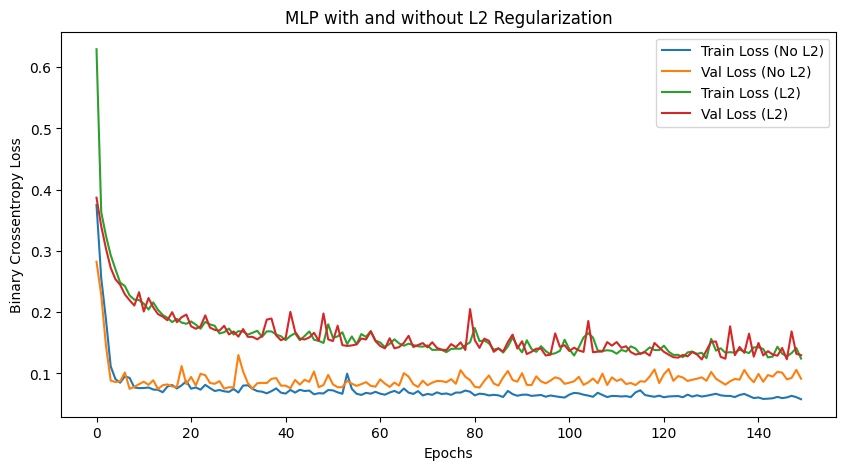

Average weight norm (No L2): 11.6855
Average weight norm (L2): 8.2571


In [6]:
# ---------------------
# 1. Build MLP with optional L2
# ---------------------
def build_mlp_l2(use_l2=False, l2_factor=0.01):
    model = Sequential()
    model.add(Input(shape=(2,)))
    if use_l2:
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_factor)))
        model.add(Dense(32, activation='relu', kernel_regularizer=l2(l2_factor)))
    else:
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ---------------------
# 2. Train Models
# ---------------------
model_no_l2 = build_mlp_l2(use_l2=False)
model_l2 = build_mlp_l2(use_l2=True, l2_factor=0.01)

history_no_l2 = model_no_l2.fit(X_train, y_train, validation_data=(X_val, y_val),
                                epochs=150, batch_size=64, verbose=0)
history_l2 = model_l2.fit(X_train, y_train, validation_data=(X_val, y_val),
                          epochs=150, batch_size=64, verbose=0)

# ---------------------
# 3. Plot Loss Curves
# ---------------------
plt.figure(figsize=(10,5))
plt.plot(history_no_l2.history['loss'], label='Train Loss (No L2)')
plt.plot(history_no_l2.history['val_loss'], label='Val Loss (No L2)')
plt.plot(history_l2.history['loss'], label='Train Loss (L2)')
plt.plot(history_l2.history['val_loss'], label='Val Loss (L2)')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.title('MLP with and without L2 Regularization')
plt.legend()
plt.show()

# ---------------------
# 4. Inspect Weight Norms
# ---------------------
import numpy as np

def average_weight_norm(model):
    total_norm = 0
    count = 0
    for layer in model.layers:
        if hasattr(layer, 'kernel'):
            weights = layer.kernel.numpy()
            total_norm += np.linalg.norm(weights)
            count += 1
    return total_norm / count

print(f"Average weight norm (No L2): {average_weight_norm(model_no_l2):.4f}")
print(f"Average weight norm (L2): {average_weight_norm(model_l2):.4f}")


**Observation**
- The model **without L2** often achieves slightly lower training loss but may overfit (higher validation loss).  
- The model **with L2 regularization** keeps validation loss lower and more stable.  
- Average weight norms are smaller for the L2 model, showing that weights are penalized and prevented from growing too large.

**Reason**
- L2 regularization adds a **parameter norm penalty** to the loss function.  
- This discourages large weights, reducing overfitting and improving generalization.
